In [224]:
pip install praw


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: c:\Users\Jakub\Documents\Kuba\Studia\Projekty GIT\Text Mining\venv\Scripts\python.exe -m pip install --upgrade pip


# ŁĄCZENIE Z API Reddita

Żeby uzyskać klucz API wystarczy zalogować się na poniższej stronie i kliknąc przycisk create another app:

https://www.reddit.com/prefs/apps

In [225]:
import praw

# === KONFIGURACJA ===
CLIENT_ID = "Placeholder"          # <- podmień
CLIENT_SECRET = "Placeholder"   # <- podmień
USER_AGENT = "reddit_text_analysis_script"
SUBREDDIT_NAME = "relationships" # <- wybrany wątek
POST_LIMIT = 500
OUTPUT_FILE = "reddit_{SUBREDDIT_NAME}posts.csv" # <- nazwa pliku

# === INICJALIZACJA API ===
reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT
)

# === POBIERANIE POSTÓW ===
subreddit = reddit.subreddit(SUBREDDIT_NAME)

posts = []
for submission in subreddit.new(limit=POST_LIMIT):
    posts.append({
        "id": submission.id,
        "title": submission.title,
        "text": submission.selftext,
        "score": submission.score,
        "url": submission.url
    })

# === ZAPIS DO CSV ===
df = pd.DataFrame(posts)
df.to_csv(OUTPUT_FILE, index=False, encoding='utf-8')

print(f"Pobrano {len(df)} postów z r/{SUBREDDIT_NAME} i zapisano do pliku: {OUTPUT_FILE}")

# Przykład – pokaż pierwsze 5 tytułów
for post in posts[:5]:
    print(post["title"])


ResponseException: received 401 HTTP response

In [ ]:
# Sprawdzenie gdzie pliki zostały zapisane
import os

print("Pełna ścieżka zapisanego pliku:")
print(os.path.abspath(OUTPUT_FILE))


Pełna ścieżka zapisanego pliku:
c:\Users\Jakub\AppData\Local\Programs\Microsoft VS Code\reddit_posts.csv


In [ ]:
# Potrzebne biblioteki -> Wpisac w terminalu

# pip install spacy
# pip install pandas 
# pip install matplotlib 
# pip install wordcloud
# pip install spacy
# pip install nltk

In [227]:

import pandas as pd
import re
import nltk
import spacy
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Wczytaj dane
df = pd.read_csv("reddit_relationships_posts.csv")

# Połącz title i text
df["content"] = df["title"].fillna("") + " " + df["text"].fillna("")

# Inicjalizacja NLP
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words

# Usuwanie wybranych słów

extra_stopwords = {
    "i", "me", "my", "mine", "myself",
    "im", "i'm", "ive", "i’ve", "i’d", "i’ll",
    "m", "s", "ve", "re", "ll", "d", "wouldnt", "couldnt", "cant", "dont", "didnt"
}
custom_stopwords = stop_words.union(extra_stopwords)



# Funkcja czyszcząca i lematyzująca
def preprocess(text):
    text = re.sub(r"http\S+|www.\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()
    doc = nlp(text)
    lemmas = [
        token.lemma_ for token in doc
        if token.lemma_.lower() not in custom_stopwords and token.is_alpha and len(token.lemma_) > 2
    ]
    return lemmas

# Przetwórz wszystkie teksty
df["lemmas"] = df["content"].apply(preprocess)

# Spłaszcz wszystkie słowa do jednej listy
all_words = [lemma for sublist in df["lemmas"] for lemma in sublist]

# Policz częstość
word_freq = Counter(all_words)

# Eliminacja rzadkich słów
filtered_words = {word: count for word, count in word_freq.items() if count > 5}





# Wykresy

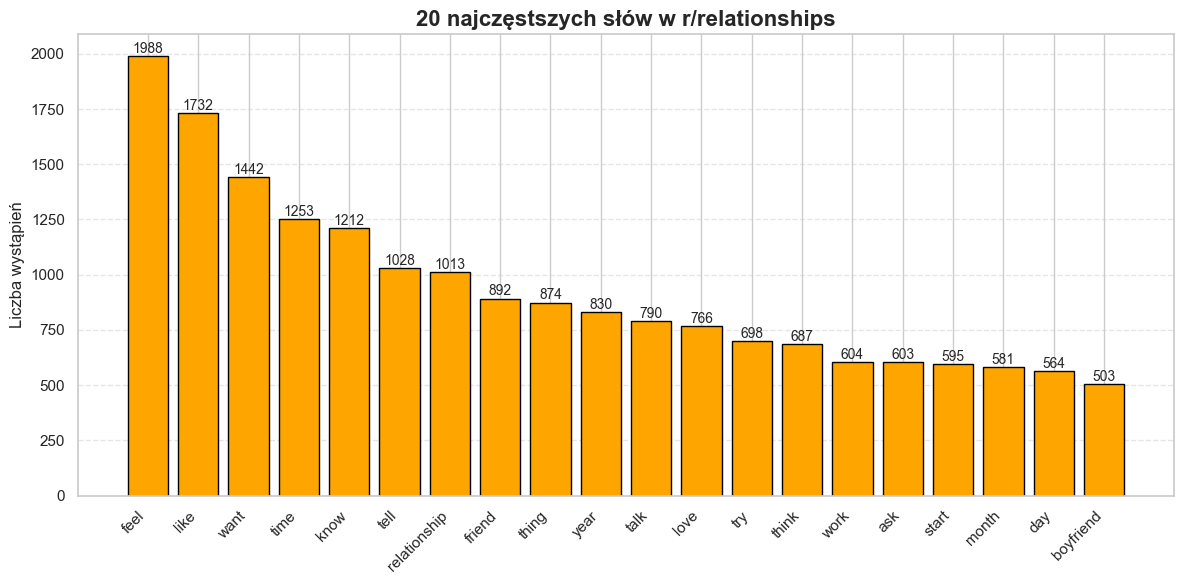

In [228]:
# 1. Wykres słupkowy najczęstszych słów
import matplotlib.pyplot as plt

# Dane
common_words = dict(Counter(filtered_words).most_common(20))
words = list(common_words.keys())
counts = list(common_words.values())

# Wykres
plt.figure(figsize=(12, 6))
bars = plt.bar(words, counts, color='orange', edgecolor='black')

# Etykiety na słupkach
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

# Styl i opis
plt.title("20 najczęstszych słów w r/relationships", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Liczba wystąpień")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


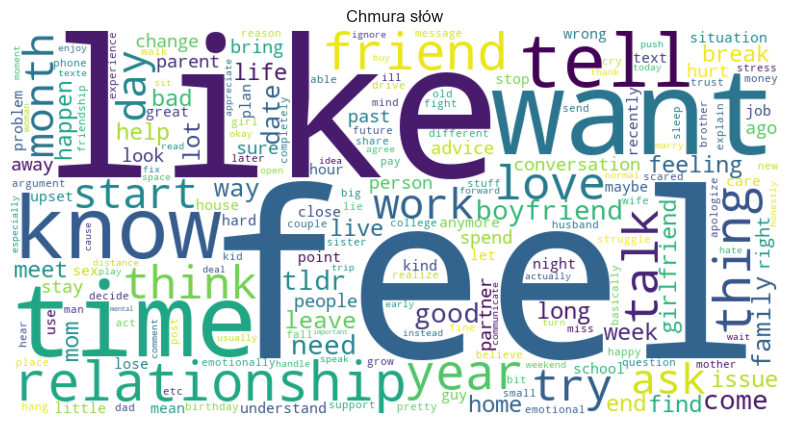

In [229]:
# 2 Chmura słów
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_words)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Chmura słów")
plt.show()

In [230]:
unwanted_words = {"thing", "day", "tldr"}

filtered_words_clean = {
    word: count for word, count in word_freq.items()
    if count > 5 and word not in unwanted_words # Usuwam niechciane słowa i takie które występują mniej niż 5 razy w zbiorze
}

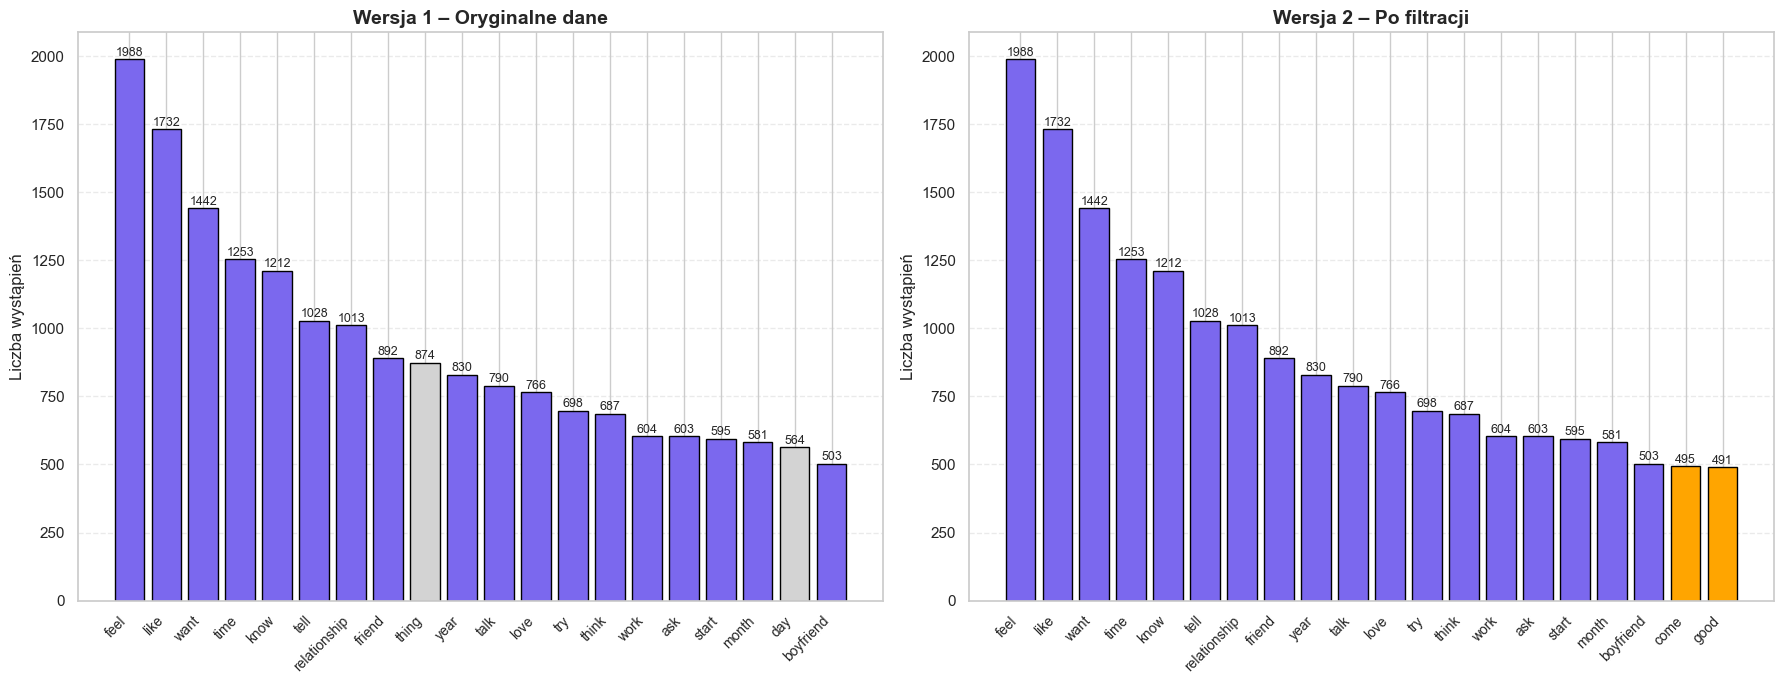

In [231]:
import matplotlib.pyplot as plt
from collections import Counter

# Dane 1 – oryginalne
words_1 = list(common_words.keys())
counts_1 = list(common_words.values())

# Dane 2 – po filtrze
top_20_words = dict(Counter(filtered_words_clean).most_common(20))
words_2 = list(top_20_words.keys())
counts_2 = list(top_20_words.values())

# Zbiory słów
set1 = set(words_1)
set2 = set(words_2)

# Wspólne i unikalne
common = set1 & set2
only_in_1 = set1 - set2
only_in_2 = set2 - set1

# === PORÓWNANIE WYKRESÓW Z KOLORAMI ===
plt.figure(figsize=(18, 7))

# Wersja 1 – oryginał
plt.subplot(1, 2, 1)
colors_1 = ['mediumslateblue' if word in common else 'lightgray' for word in words_1]
bars1 = plt.bar(words_1, counts_1, color=colors_1, edgecolor='black')
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=9)
plt.title("Wersja 1 – Oryginalne dane", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel("Liczba wystąpień")
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Wersja 2 – po filtracji
plt.subplot(1, 2, 2)
colors_2 = ['mediumslateblue' if word in common else 'orange' for word in words_2]
bars2 = plt.bar(words_2, counts_2, color=colors_2, edgecolor='black')
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=9)
plt.title("Wersja 2 – Po filtracji", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel("Liczba wystąpień")
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


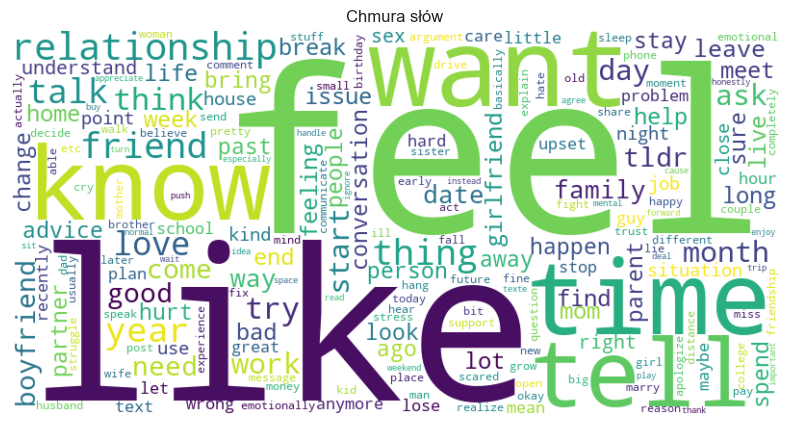

In [232]:
# 2 Chmura słów po filtrowaniu
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_words)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Chmura słów")
plt.show()

# Wnioski
Analiza najczęściej używanych słów wskazuje, że posty w r/relationships są silnie nacechowane emocjonalnie i introspekcyjnie. Użytkownicy skupiają się na uczuciach, potrzebach, relacjach z partnerami oraz próbach zrozumienia i naprawy trudnych sytuacji interpersonalnych.

## Tematyka emocjonalna jest dominująca

Użytkownicy reddita wątku r/relationships zdecydowanie koncentrują się na swoim stanie emocjonalnym i potrzebach

Najczęstsze słowa to:
feel, like, want, love, think, know, try

To silnie subiektywne i introspekcyjne słowa, wskazujące na:

- wyrażanie emocji,
- potrzebę zrozumienia sytuacji,
- próby analizy własnych uczuć.

## Związki i relacje są kluczowym motywem

Słowa takie jak: 
relationship, friend, boyfriend, love, come 

Wskazują na to, że autorzy często analizują relacje międzyludzkie (z partnerem, przyjaciółmi), często omawiają kwestie dotyczące partnerów (boyfriend) lub zmian w relacji (come, go, start).

## Czas i długość trwania relacji są istotnymi elementami:

Słowa takie jak:
time, year, month, start

mogą mówić o:

- długości relacji,
- przeszłośćci i teraźniejszość w związku,
- przedstawiać punkty zwrotne (np. „we started dating 6 months ago”).

## Komunikacja i działanie: kluczowe dla konfliktów

Słowa typu:
talk, tell, ask, work, try, come

pokazują, że autorzy:

- szukają sposobu na rozwiązanie problemów,
- koncentrują się na rozmowie, pytaniu, działaniu – co sugerują poniższe zdania:
         „chcę coś naprawić, ale nie wiem jak” lub „nie potrafię się dogadać”.

## Ton narracji: introspekcyjny i problemowy

Dominujące czasowniki (feel, want, try, think) wskazują na to, że:

- użytkownicy najczęściej nie opisują faktów, ale dzielą się przemyśleniami i uczuciami,
- ton wypowiedzi jest osobisty i emocjonalny.

# Bigramy

In [233]:
import nltk
from nltk.util import bigrams

# Tworzenie bigramów
bigram_list = list(bigrams(all_words))
bigram_freq = Counter(bigram_list)

# Filtrowanie
filtered_bigrams = {
    f"{w1} {w2}": count for (w1, w2), count in bigram_freq.items() if count > 5
}

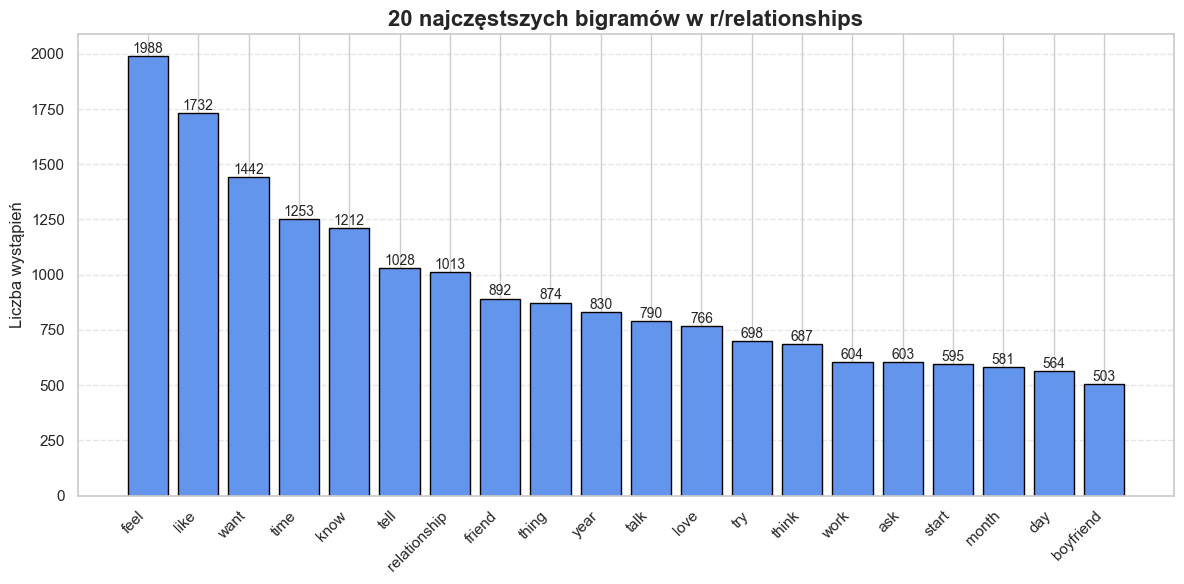

In [235]:
import matplotlib.pyplot as plt

# Dane
common_words_bigrams = dict(Counter(filtered_bigrams).most_common(20))
words = list(common_words.keys())
counts = list(common_words.values())

# Wykres
plt.figure(figsize=(12, 6))
bars = plt.bar(words, counts, color='cornflowerblue', edgecolor='black')

# Etykiety na słupkach
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}', 
             ha='center', va='bottom', fontsize=10)

# Styl i opis

plt.title("20 najczęstszych bigramów w r/relationships", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Liczba wystąpień")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

C:\Users\Jakub\AppData\Local\Temp\ipykernel_32016\2270879468.py:15: UserWarning: Glyph 9729 (\N{CLOUD}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jakub\AppData\Local\Temp\ipykernel_32016\2270879468.py:15: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Jakub\Documents\Kuba\Studia\Projekty GIT\Text Mining\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9729 (\N{CLOUD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Jakub\Documents\Kuba\Studia\Projekty GIT\Text Mining\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


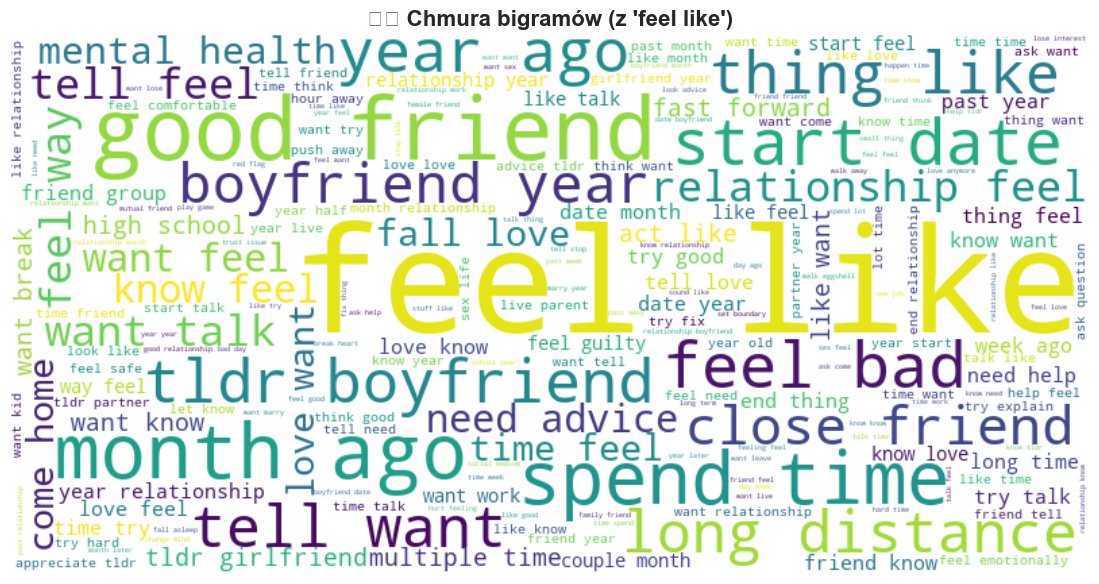

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Chmura z bigramem "feel like"
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(filtered_bigrams)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Chmura bigramów (z 'feel like')", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


1. Najczęstszy bigram feel like pojawił się znacznie częściej niż pozostałe. Ze względu na jego ogólnikowość i zaburzenie proporcji wykresu, został wykluczony z końcowej wizualizacji
2. fraza "tldr boyfriend" również została usunięta ponieważ nie zawiera semantyki, tak samo jak wiele innych wyrazów

In [237]:
# Usuwanie bigramów nie zawierających semantyki
to_remove = {
    "feel like", "tldr boyfriend", "month ago", "year ago",
    "thing like", "spend time", "start date", "tell want", "tell feel",
    "feel way", "know feel", "like want", "time feel", "multiple time",
    "tldr girlfriend", "fall love", "come home", "relationship feel",
    "high school", "week ago", "date year", "date month",
    "fast forward", "boyfriend year"
}

# Nowy df – bez nieistotnych bigramów
cleaned_bigrams = {
    bigram: count for bigram, count in filtered_bigrams.items()
    if bigram not in to_remove
}


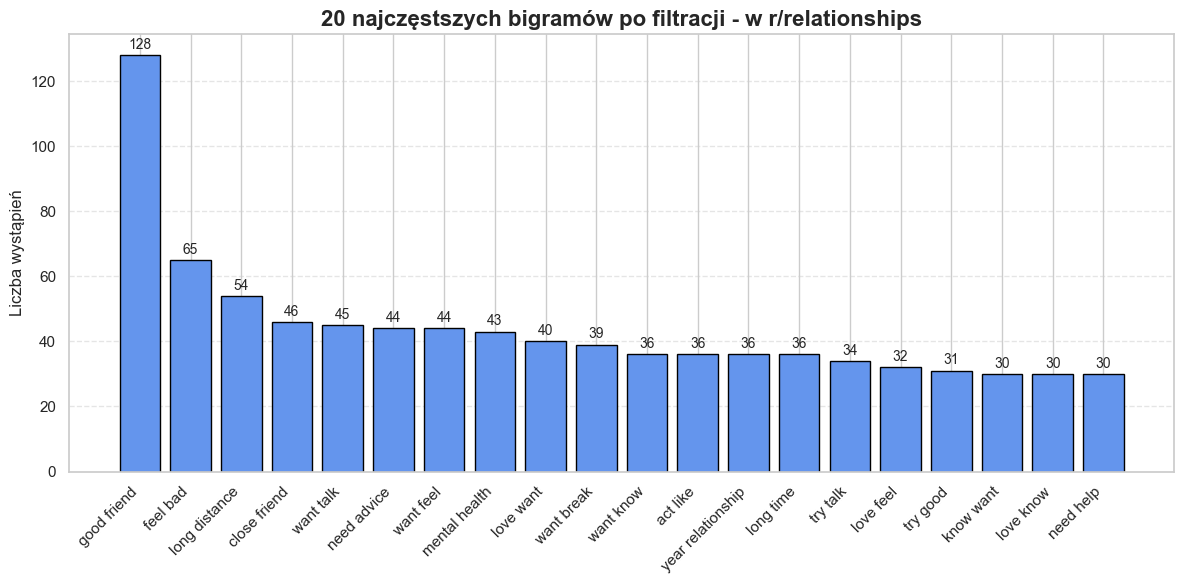

In [239]:
import matplotlib.pyplot as plt

# Dane
common_words = dict(Counter(cleaned_bigrams).most_common(20))
words = list(common_words.keys())
counts = list(common_words.values())

# Wykres
plt.figure(figsize=(12, 6))
bars = plt.bar(words, counts, color='cornflowerblue', edgecolor='black')

# Etykiety na słupkach
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}', 
             ha='center', va='bottom', fontsize=10)

# Styl i opis

plt.title("20 najczęstszych bigramów po filtracji - w r/relationships", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Liczba wystąpień")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


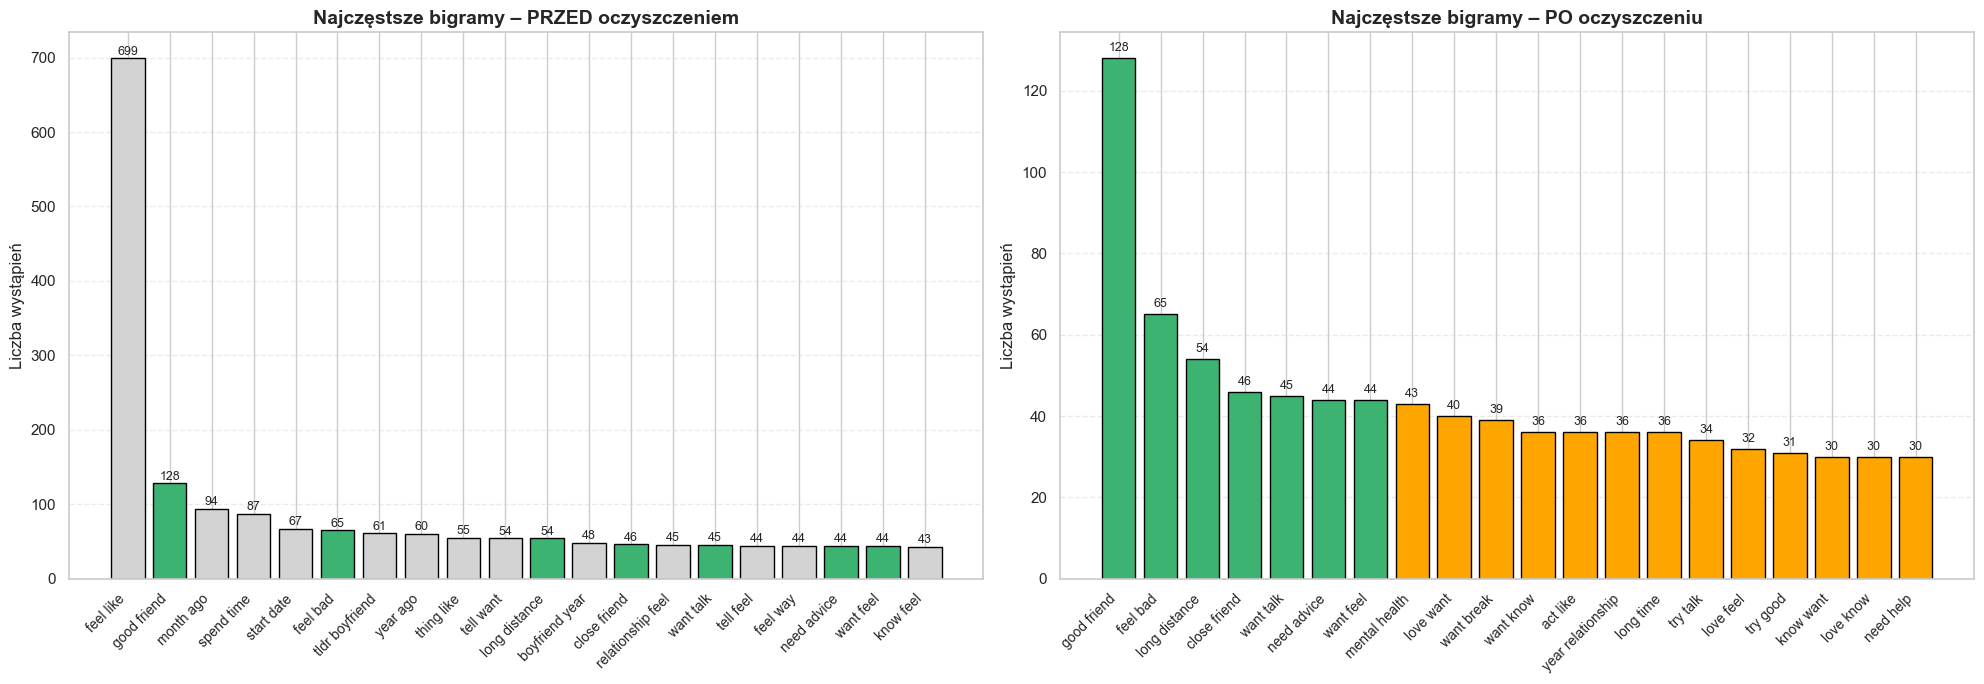

In [240]:
import matplotlib.pyplot as plt
from collections import Counter

# Dane
bigrams_raw = dict(Counter(filtered_bigrams).most_common(20))
bigrams_clean = dict(Counter(cleaned_bigrams).most_common(20))

# Listy i zbiory
words_raw = list(bigrams_raw.keys())
counts_raw = list(bigrams_raw.values())

words_clean = list(bigrams_clean.keys())
counts_clean = list(bigrams_clean.values())

set_raw = set(words_raw)
set_clean = set(words_clean)

# Wspólne, nowe i usunięte
common = set_raw & set_clean
removed = set_raw - set_clean
new = set_clean - set_raw

# === WYKRESY OBOK SIEBIE ===
plt.figure(figsize=(20, 7))

# 1️⃣ WYKRES: PRZED oczyszczeniem
plt.subplot(1, 2, 1)
colors1 = ['mediumseagreen' if w in common else 'lightgray' for w in words_raw]
bars1 = plt.bar(words_raw, counts_raw, color=colors1, edgecolor='black')
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=9)
plt.title("Najczęstsze bigramy – PRZED oczyszczeniem", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel("Liczba wystąpień")
plt.grid(axis='y', linestyle='--', alpha=0.4)

# 2️⃣ WYKRES: PO oczyszczeniu
plt.subplot(1, 2, 2)
colors2 = ['orange' if w in new else 'mediumseagreen' for w in words_clean]
bars2 = plt.bar(words_clean, counts_clean, color=colors2, edgecolor='black')
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=9)
plt.title("Najczęstsze bigramy – PO oczyszczeniu", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel("Liczba wystąpień")
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


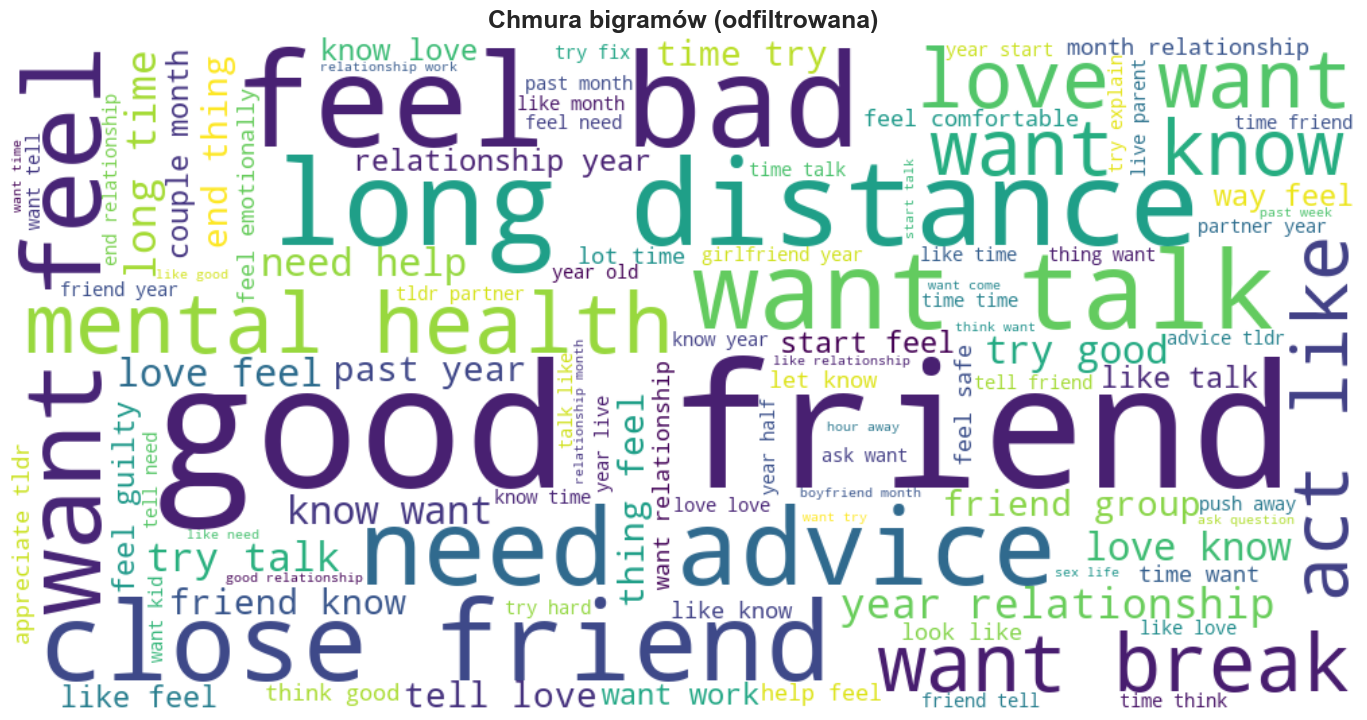

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Estetyczna konfiguracja chmury
bigram_wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    colormap='viridis',           # inne: 'plasma', 'cool', 'magma', 'cubehelix'
    max_words=100,
    prefer_horizontal=0.9,
    contour_color='steelblue',
    contour_width=1,
    random_state=42
).generate_from_frequencies(cleaned_bigrams)

# Wykres
plt.figure(figsize=(14, 7))
plt.imshow(bigram_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Chmura bigramów (odfiltrowana)", fontsize=18, fontweight='bold')
plt.tight_layout(pad=0)
plt.show()


# Wnioski z analizy bigramów
Najczęstsze bigramy w postach z r/relationships pokazują, że użytkownicy zmagają się przede wszystkim z emocjami, niepewnością i komunikacją w relacjach — zarówno romantycznych, jak i przyjacielskich. 
Dane ujawniają wysoki poziom introspekcji i potrzebę zrozumienia lub wsparcia, a także częste odniesienia do związków na odległość i problemów zdrowia psychicznego.

## Relacje przyjacielskie i bliskie znajomości mają ogromne znaczenie
Najczęstszy bigram to good friend, a także w zbiorze widać frazy close friend i friend group.

Pokazuje to, że użytkownicy często opisują swoje relacje z przyjaciółmi, nie tylko partnerami.

Możliwe tematy: 
- uczucia do przyjaciela, 
- konflikty w grupie znajomych, 
- „friendzone”.

## Emocje i psychiczne samopoczucie są dominującym motywem

Bigramy takie jak feel bad, mental health, love feel, try good, need help wskazują na:

- wysoki poziom autorefleksji,
- emocjonalne cierpienie,
- szukanie wsparcia i zrozumienia.
- Subreddit pełni wyraźnie funkcję emocjonalnego wentyla.

## Związki na odległość i złożone sytuacje romantyczne

1. Bigram long distance jest trzeci na liście — to wyraźny sygnał, że wiele osób porusza temat trudności w relacjach na odległość.

2. W połączeniu z frazami love want, want break, year relationship pokazuje to zróżnicowane etapy i kryzysy w związkach.

## Potrzeba komunikacji i zrozumienia
Bigramy: want talk, try talk, need advice, know want

- Wskazują na problem z komunikacją i chęć rozwiązania sytuacji poprzez rozmowę lub pytanie innych o radę.

- Wysoka częstotliwość tych wyrażeń pokazuje, że brak komunikacji jest jednym z najczęstszych powodów postów.

## Złożoność relacji romantycznych
Bigramy: love want, want know, love know, want break, year relationship

- Wskazują na ambiwalencję emocjonalną, konflikty między uczuciem a działaniem.

- Użytkownicy często są na rozdrożu: „czy zostać, czy odejść?”, „czy to jeszcze miłość, czy już przyzwyczajenie?”

In [241]:
# Sprawdzenie wystąpień poszczególnych zestawów

from collections import defaultdict

# Tworzenie struktury: {rdzeń: [(bigram, liczba)]}
bigram_groups = defaultdict(list)

for bigram, count in filtered_bigrams.items():
    w1, w2 = bigram.split()
    bigram_groups[w1].append((f"{w1} {w2}", count))

# Sortowanie każdego zestaw według liczby wystąpień
for root in bigram_groups:
    bigram_groups[root].sort(key=lambda x: x[1], reverse=True)

# Pokaż wybrane rdzenie
selected_roots = ["want", "feel", "try", "love"]

for root in selected_roots:
    print(f"\nBigramy zaczynające się od '{root}':")
    for bigram, count in bigram_groups[root]:
        print(f"  {bigram}: {count}")



Bigramy zaczynające się od 'want':
  want talk: 45
  want feel: 44
  want break: 39
  want know: 36
  want work: 25
  want relationship: 23
  want tell: 19
  want kid: 19
  want come: 18
  want time: 18
  want try: 18
  want sex: 17
  want leave: 16
  want want: 16
  want live: 15
  want marry: 14
  want lose: 14
  want start: 14
  want thing: 13
  want spend: 13
  want love: 13
  want partner: 12
  want friend: 12
  want hurt: 12
  want hear: 11
  want meet: 11
  want happy: 11
  want continue: 10
  want change: 10
  want hang: 10
  want end: 10
  want stay: 9
  want bring: 9
  want ask: 9
  want like: 9
  want family: 9
  want understand: 8
  want let: 8
  want think: 7
  want help: 7
  want breakup: 7
  want good: 7
  want anymore: 7
  want play: 7
  want support: 6
  want future: 6
  want wait: 6
  want sure: 6
  want day: 6
  want kiss: 6
  want share: 6
  want boyfriend: 6

Bigramy zaczynające się od 'feel':
  feel like: 699
  feel bad: 65
  feel way: 44
  feel guilty: 25
  feel

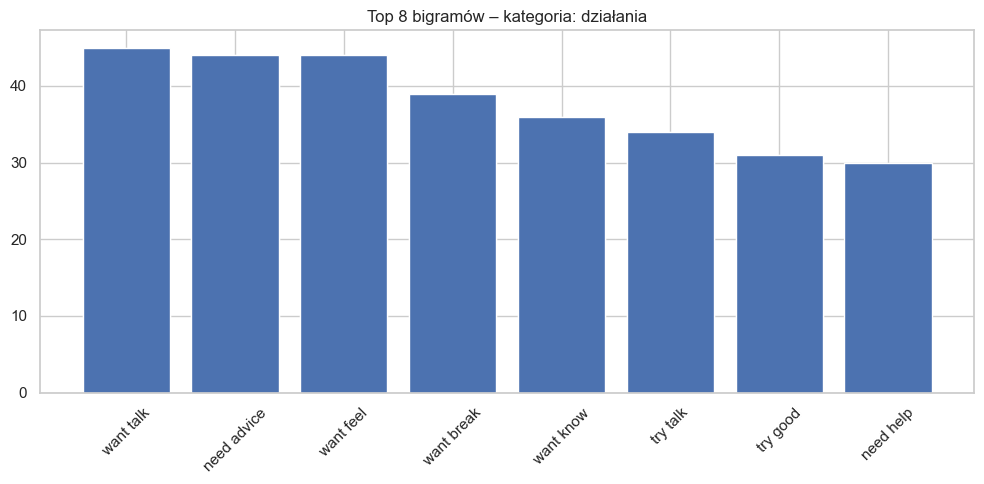

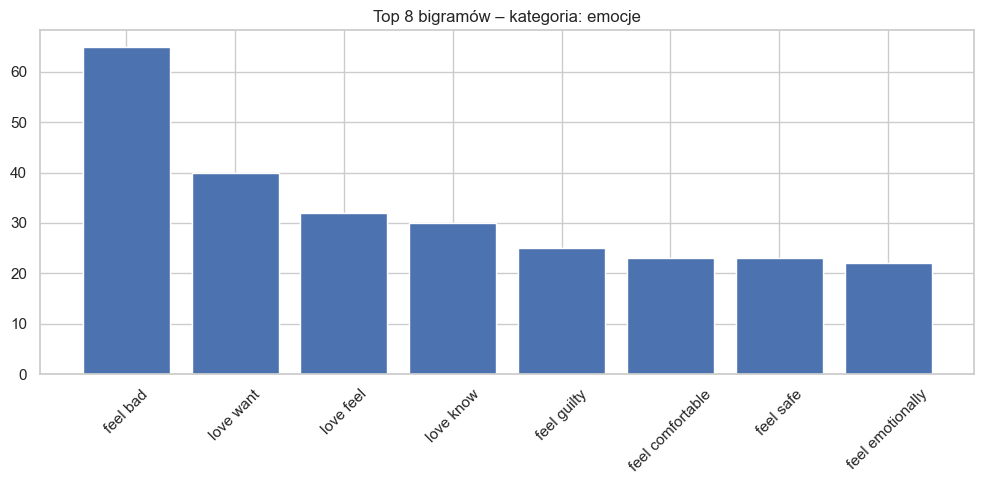

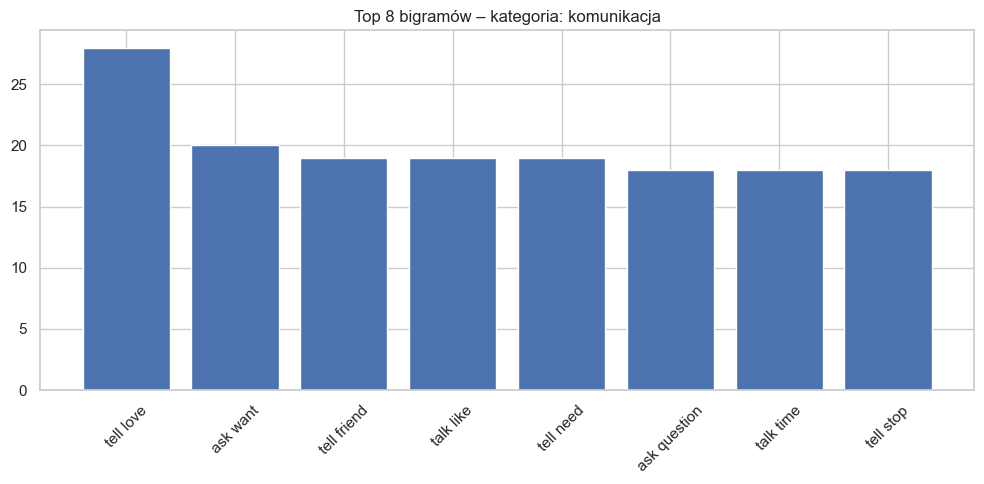

In [246]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Kategorie tematyczne na podstawie rdzeni
category_roots = {
    "emocje": {"feel", "love"},
    "działania": {"want", "need", "try"},
    "komunikacja": {"talk", "say", "tell", "ask"},
}

# Przypiszemy bigramy do kategorii
categorized_bigrams = defaultdict(list)

for bigram, count in cleaned_bigrams.items():
    w1, w2 = bigram.split()
    if w1 == w2:
        continue  # pomiń duplikaty np. love love, feel feel
    for category, root_set in category_roots.items():
        if w1 in root_set:
            categorized_bigrams[category].append((bigram, count))
    root = bigram.split()[0]
    for category, root_set in category_roots.items():
        if root in root_set:
            categorized_bigrams[category].append((bigram, count))

# Rysowanie wykresów dla każdej kategorii 
for category, items in categorized_bigrams.items():
    # sortowanie malejąco
    items = sorted(items, key=lambda x: x[1], reverse=True)[:15] 
    bigrams = [x[0] for x in items]
    counts = [x[1] for x in items]

    # wykres
    plt.figure(figsize=(10, 5))
    plt.bar(bigrams, counts)
    plt.xticks(rotation=45)
    plt.title(f"Top 8 bigramów – kategoria: {category}")
    plt.tight_layout()
    plt.show()


# Wnioski 

## Kategoria „działania"

### Użytkownicy wykazują dużą potrzebę komunikacji
Bigramy:
- want talk
- try talk

znajdują się na szczycie zestawienia. To pokazuje, że autorzy postów:

1. chcą rozmawiać ze swoimi partnerami lub przyjaciółmi,
2. próbują rozwiązać konflikty poprzez dialog,
3. często zmagają się z brakiem skutecznej komunikacji.

### Poszukiwania wsparcia i porady
Bigramy:
- need advice
- need help

wskazują, że użytkownicy:

1. często nie potrafią samodzielnie rozwiązać swoich problemów,
2. aktywne poszukiwanie pomocy to częsty motyw na subreddicie,
3. Reddit pełni funkcję społecznościowego „doradcy”.

### Często stoją przed decyzją o zakończeniu relacji

- want break – sugeruje chęć zakończenia związku.

- want know – może oznaczać niepewność decyzyjną, potrzebę wyjaśnienia sytuacji, np. „czy on mnie kocha?”, „czy to ma sens?”.

Wniosek: działania związane z rozstaniem i wątpliwościami są powszechne.

### Intencje działania są emocjonalnie nacechowane mające na celu poprawę relacji

- try good – nietypowy, ale znaczący bigram. Może odnosić się do:
    - prób „bycia dobrym partnerem”,
    - wewnętrznej potrzeby poprawy siebie lub sytuacji.

- want work – często występujący w kontekście: „chcę, żeby to zadziałało”, „chcę naprawić związek”.

## Kategoria „emocje”
### Negatywne emocje są najczęściej wyrażane

Najczęstszy bigram to feel bad, a zaraz za nim:
- feel guilty, love want, love feel

Użytkownicy często piszą o:

- wyrzutach sumienia,
- niezadowoleniu z relacji,
- trudnych emocjach związanych z miłością.

To potwierdza, że wątek ma charakter kryzysowy i introspekcyjny.

### Miłość wiąże się z niepewnością i konfliktami
Bigramy:
- love want
- love feel
- love know

Wskazują na to, że uczucia nie są proste – często występują obok:

- chęci czegoś więcej,
- braku pewności co do własnych emocji,
- lub potrzeby zrozumienia drugiej strony.

### Bezpieczeństwo emocjonalne jest ważnym tematem
- feel safe
- feel comfortable
- feel emotionally

to sygnał, że wiele osób:

- ocenia swoje związki przez pryzmat emocjonalnego komfortu,
- brak poczucia bezpieczeństwa może być impulsem do napisania posta.

## Kategoria „działania"

### Komunikacja o uczuciach jest kluczowa
Najczęstszy bigram: tell love

- Użytkownicy często rozważają, czy:
    - powiedzieć drugiej osobie, że ją kochają,
    - wyznać uczucia po czasie,
    - a także martwią się, że nie potrafią tego zrobić.

Podsumowując, wyrażanie emocji werbalnie to jedna z najczęstszych trudności i tematów w relacjach.

### Komunikacja potrzeb i decyzji
Bigramy: tell need, ask want, tell stop

Wskazują na próbę:
- wyrażenia własnych granic i potrzeb,
- powiedzenia komuś, żeby coś zakończył lub zmienił.

Interpretacja: Reddit pełni rolę miejsca, gdzie ludzie uczą się, jak komunikować własne oczekiwania i potrzeby emocjonalne.

### Rozmowy z osobami trzecimi i doradztwo

- tell friend, 
- ask question

Pokazuje, że:
- użytkownicy dzielą się problemami z przyjaciółmi,
- szukają zewnętrznej opinii (np. od znajomych lub społeczności Reddita).


# Podsumowanie

Subreddit r/relationships pełni funkcję emocjonalnego wentyla i miejsca szukania wsparcia. 
Wypowiedzi użytkowników są zdominowane przez introspekcję, emocjonalne napięcia i trudności komunikacyjne. 
Użytkownicy często dzielą się swoimi wątpliwościami i szukają porady dotyczącej decyzji w związkach i przyjaźniach. 
Analiza słów i bigramów pokazała, że najważniejszymi osiami tematycznymi są: emocje, działania (decyzje) i komunikacja, a język użytkowników odzwierciedla typowe problemy współczesnych relacji międzyludzkich.

Najczęstsze frazy związane z działaniem ujawniają, że użytkownicy r/relationships są zorientowani na rozwiązywanie problemów, ale często czują się zagubieni i bezradni. 
Poszukują rozmowy, rady i jasności, a niejednokrotnie rozważają zerwanie lub ratowanie związku. 
Widać silną potrzebę działania, ale też brak narzędzi lub odpowiedzi, jak to zrobić.

Emocjonalna warstwa postów w r/relationships pokazuje silne nacechowanie negatywnymi uczuciami — takimi jak poczucie winy, smutek czy brak bezpieczeństwa. 
Użytkownicy zmagają się z niepewnością co do miłości oraz własnych emocji, poszukując zrozumienia, ulgi i emocjonalnego wsparcia.

Komunikacja — zarówno werbalna, jak i niewerbalna — jest jednym z najczęstszych źródeł napięcia w związkach opisywanych na r/relationships. 
Użytkownicy szukają sposobów na wyrażanie emocji, granic i potrzeb, a także często angażują osoby trzecie (przyjaciół, społeczność), by zrozumieć, jak i co powiedzieć. 
Trudności te często wynikają z niepewności, lęku przed reakcją drugiej osoby lub braku umiejętności komunikacyjnych.
